In [92]:
# imports, note scipy>=1.8 is needed
import numpy as np
import random
import networkx as nx
import re
from IPython.display import Image
import matplotlib.pyplot as plt
import collections
from matplotlib.ticker import MaxNLocator
import community
import statistics as stats
from collections import Counter
import seaborn as sns
from matplotlib import rc
import pandas as pd
import csv
import sklearn.cluster
import scipy
import plotly
import plotly.graph_objs as go
print("done")

done


In [93]:

file = open("list_of_characters.txt", "r", encoding="utf8")
content = file.read()
file.close()

list_of_characters = re.split(' \n | \n|\n |\n', content)
for i in range(len(list_of_characters)):
    list_of_characters[i] = list_of_characters[i].split(' / ')

file = open("war_and_peace.txt", encoding="utf8")
# print(file.read())
content = file.read()
file.close()

chapter_list = content.split("\n")

# print(chapter_list[40])

# print(len(chapter_list))

# found a name at least founded once in the text not the same as one in the list

print(len(list_of_characters))

counter=0
for character in list_of_characters:
    appears = False
    for name in character:
        # print(character)
        for i in range(len(chapter_list)):
            if chapter_list[i].find(name) != -1:
                appears = True
    if not appears:
        list_of_characters.remove(character)
        # print(character)





50


In [126]:
# make graph


from platform import node


G = nx.Graph()

for character in list_of_characters:
    G.add_node(str(character))

for chapter in chapter_list:
    characters_appear = []
    for character in list_of_characters:
        for name in character:
            if chapter.find(name) != -1:
                characters_appear.append(character)
    for character1 in characters_appear:
        for character2 in characters_appear:
            if (character1!=character2):
                n0 = str(character1)
                n1 = str(character2)
                if G.has_edge(n0,n1):   
                    pass
                    # G[n0][n1]['weight'] += 1
                else:
                    G.add_edge(n0,n1, weight=1)

# print(G.degree())



nb = nx.number_connected_components(G)
print(nb)


S = G.subgraph(max(nx.connected_components(G), key=len))






6


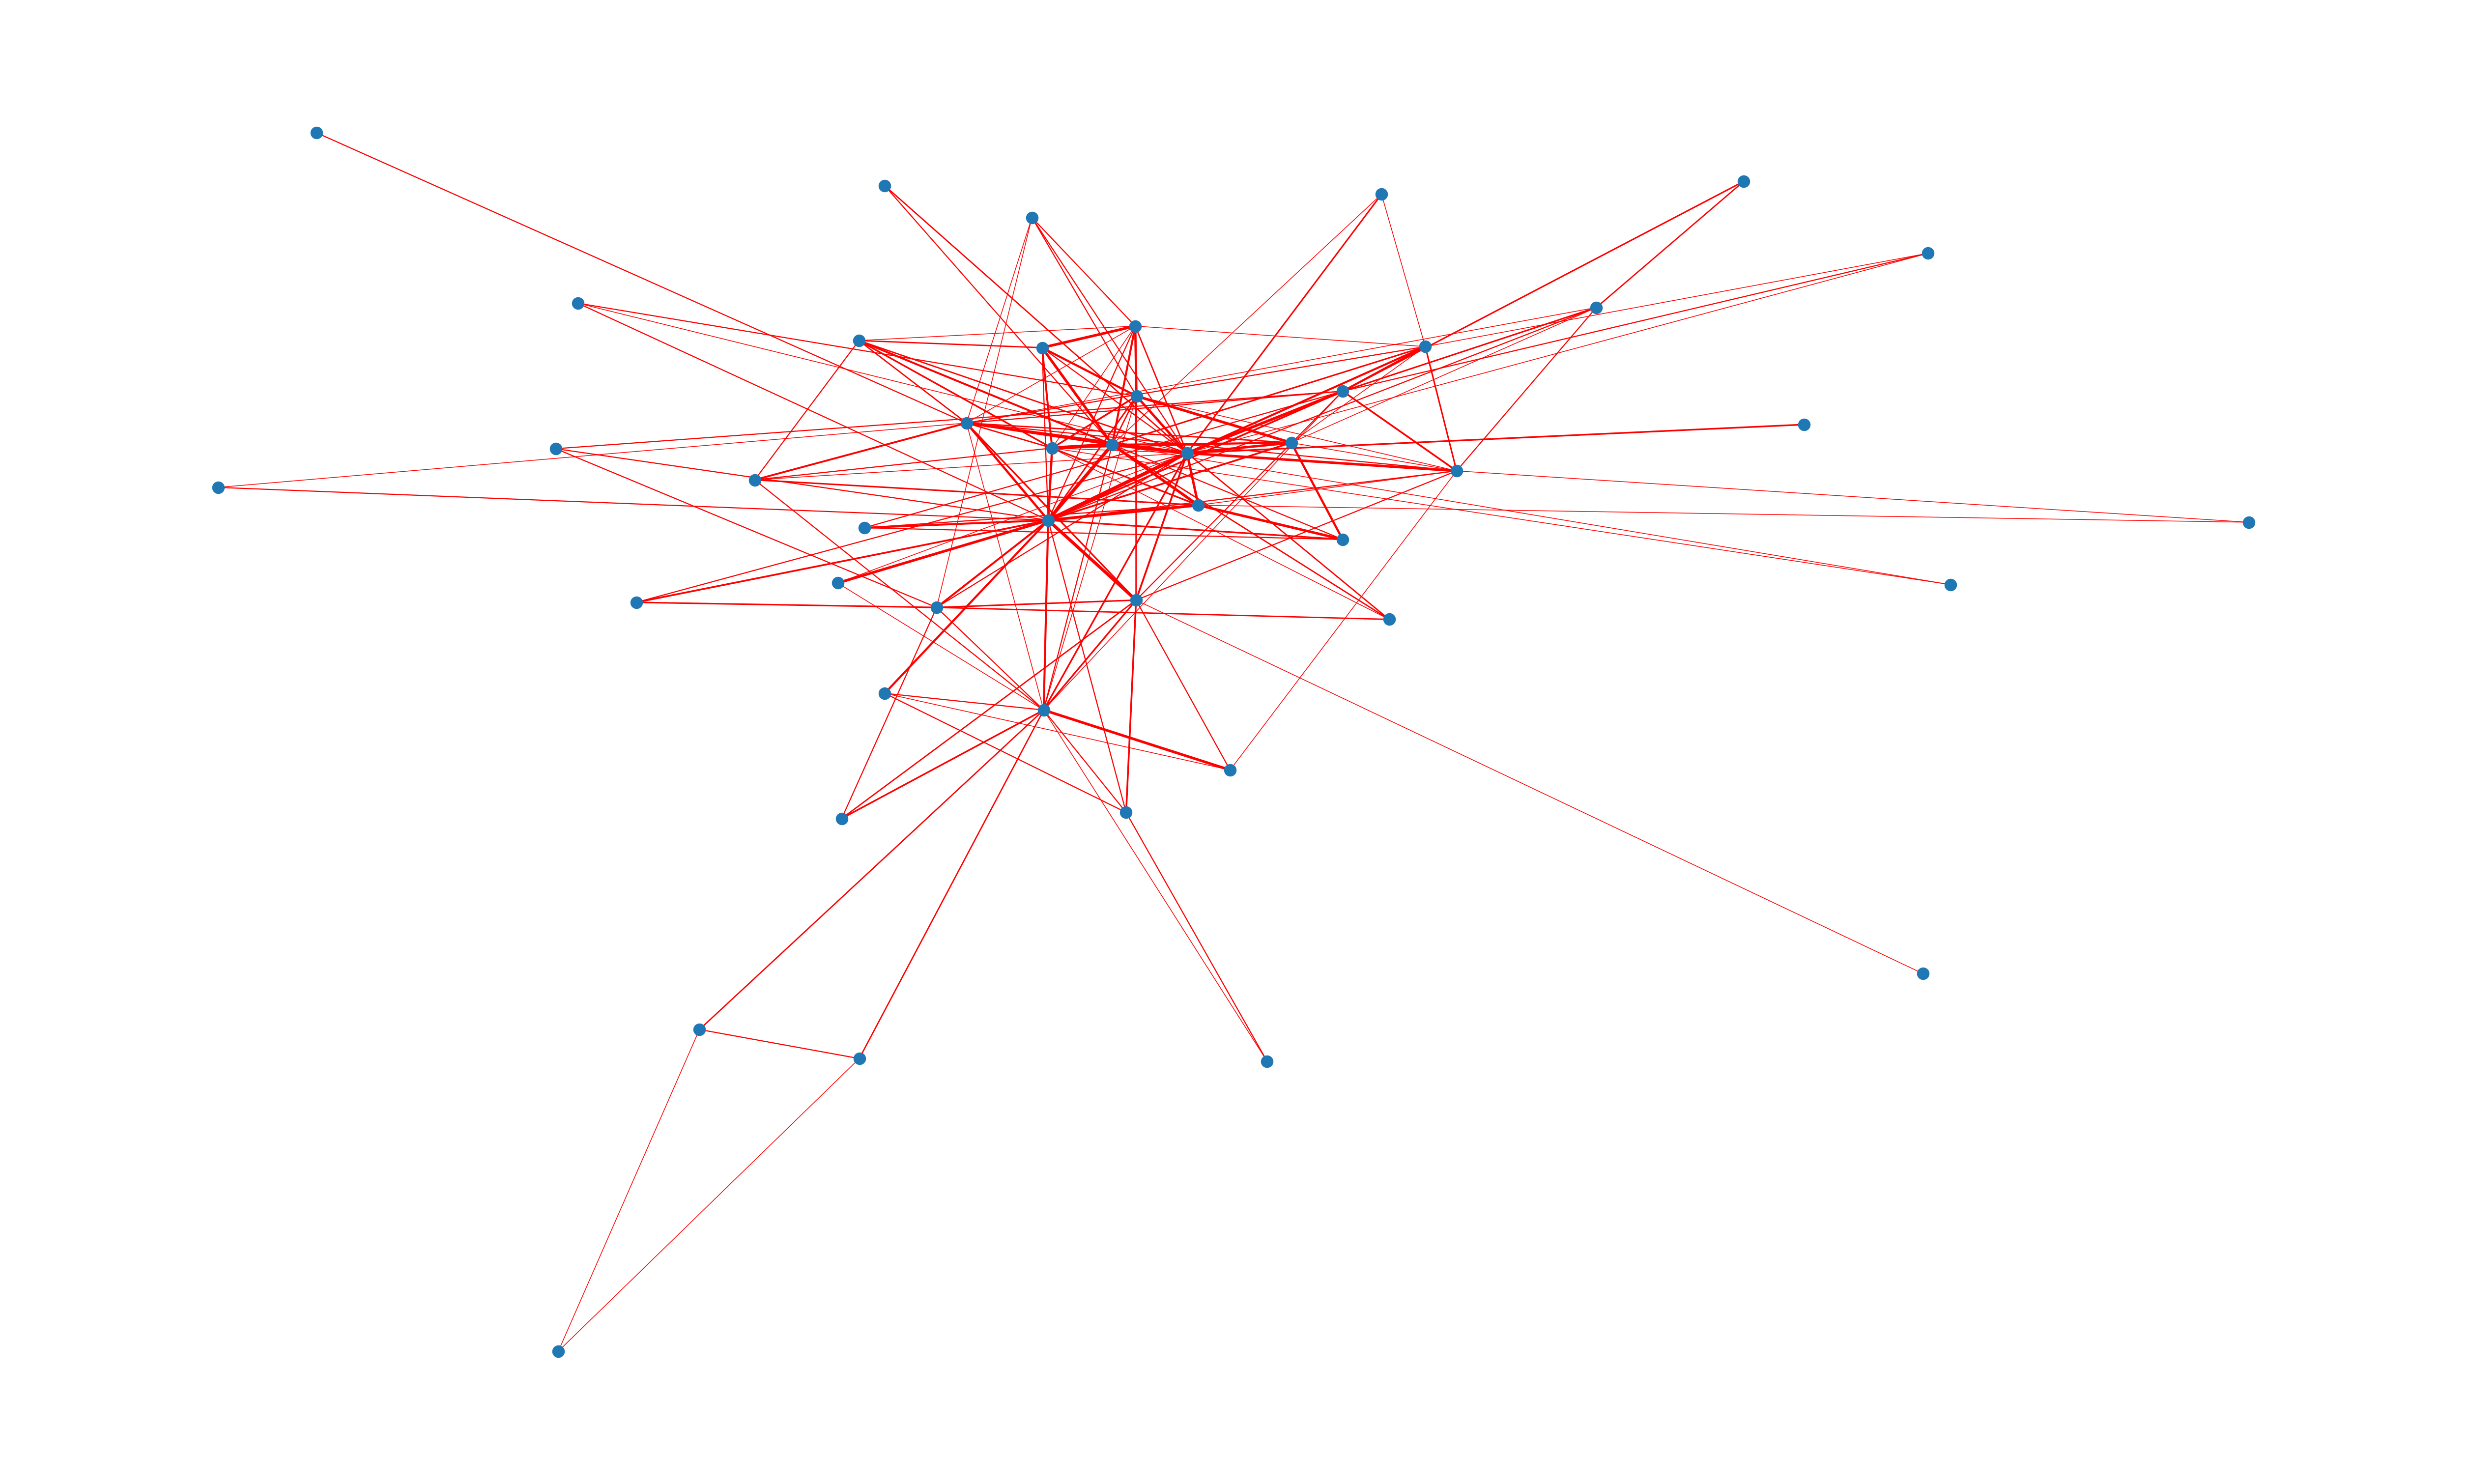

In [95]:

edges = G.edges()
weights = np.log([S[u][v]['weight']+1 for u,v in edges])

fig = plt.figure(1, figsize=(50, 30), dpi=100)
# nx.draw_networkx(S, with_labels=True, width=weights, edge_color='r')
# nx.draw_random(S, with_labels=True, width=weights, edge_color='r')
# nx.draw_circular(S, with_labels=True, width=weights, edge_color='r') 
# nx.draw_spectral(S, with_labels=True, width=weights)  
fig = nx.draw_spring(S, with_labels=False, width=weights, edge_color='r', font_size=25) 
# fig =nx.draw(S, with_labels=True, width=weights,  edge_color='r', font_size=30) 



In [127]:

# Maximising the influence in the graph
# • Imagine there is an important rumour to spread in your network. You want it to
# quickly reach all the people, thus you want to solve the influence
# maximisation problem. Implement the greedy algorithm from the lectures and
# identify the set MI of maximal influence of size k = 5% of the nodes.


# print(S.number_of_nodes())
# print(sorted(S.degree, key=lambda x: x[1], reverse=True))
# print(nx.degree_assortativity_coefficient(S))

# print(nx.adjacency_matrix(S))
adj = nx.adjacency_matrix(S).toarray().astype(np.float64)
maxim = np.max(adj)
adj/=maxim*2
# print(adj)


def decision(probability):
    return random.random() < probability


def ICM(p_matrix:np.matrix, nbsteps:int, set_infected_nodes:set, gamma:int)->int:

    set_already_infected_nodes = set_infected_nodes.copy()
    # print(set_already_infected_nodes)

    for i in range(nbsteps):
        for node in set_infected_nodes.copy():
            for index in range(p_matrix.shape[0]):
                p = p_matrix[node][index]
                if decision(p):
                    if (index not in set_already_infected_nodes):
                        set_infected_nodes.add(index) 
                    set_already_infected_nodes.add(index)

            if decision(gamma):
                set_infected_nodes.remove(node)

        # print(set_infected_nodes)

        if (len(set_infected_nodes)==0):
            break
    return set_already_infected_nodes



# ICM(adj, 100000, set([0, 1, 2, 3, 4]), 0.02)



# Greedy hill-climbing heuristic:
# Given a graph G(V,E) and an ICM model defined on G
# 1) Generate a large number of realisations Xi
# of the ICM on G
# 2) Initialise A0
#  = [ ]
# 3) While length(A0
# ) < k:
# Find v in V \ A0
# that maximizes Σ P(Xi
# )𝜎Xi(A0 ∪ {v})
# Add v to A0
# The final set A0
# is the optimal set of the influence maximization problem, with optimality bounds given
# above.

nbsteps = 10000000
nbrealisations=100000
nb_characters = 20
gamma = 1

def greedy_hill_climbing(adj, nbsteps, gamma, nb_characters):
    list_of_realisations = []
    for i in range(nbrealisations):
        sample =set(random.sample(range(45), nb_characters))
        realisation = ICM(adj, nbsteps, sample, gamma)
        list_of_realisations.append(realisation)

    A0 = []
    A1 = list(range(45))

    while len(A0)<nb_characters:
        sigmas = list(np.zeros(45))
        for i in A1:
            sumOfSigmas = 0
            for realisation in list_of_realisations:
                if i in realisation:
                    for j in A0:
                        if j in realisation:
                            sumOfSigmas+=len(realisation)
                    if len(A0)==0:
                        sumOfSigmas+=len(realisation)
            sigmas[i] = sumOfSigmas
        # print(sigmas)
        maxim = max(sigmas)
        max_index = sigmas.index(maxim)
        A0.append(max_index)
        A1.remove(max_index)
    return A0

A0 =greedy_hill_climbing(adj, nbsteps, gamma, nb_characters)
print(A0)





[0, 7, 10, 15, 20, 21, 14, 16, 30, 31, 29, 18, 19, 2, 27, 12, 13, 34, 17, 11]


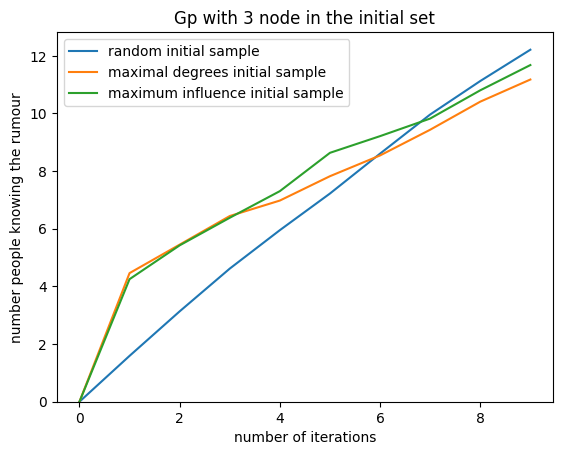

In [124]:
# • Implement the independent cascade model on this network and use it to
# compare the outcomes starting from the obtained set MI with similar size set of
# nodes of largest degrees and a random selection. Comparison can be made by
# the total size of people reached by a cascade or by the spreading curve: (t,Y(t))
# - curve, where t in discrete time and Y(t) is the total average proportion of
# “infected” people at time t.


nb_characters=10

Gp = [0, 7, 10, 14, 2, 21, 30, 15, 13, 18, 31, 29, 20, 16, 3, 19, 23, 27, 12, 22]
Gu = [0, 7, 10, 15, 20, 21, 14, 16, 30, 31, 29, 18, 19, 2, 27, 12, 13, 34, 17, 11]


degrees = [list((node,int(val))) for (node, val) in S.degree()]

# print(degrees)
def givedegree(node):
    return node[1]


high_degree = []
for i in range(nb_characters):
    maxim = max(degrees, key=givedegree)
    index = degrees.index(maxim)
    high_degree.append(index)
    degrees[index][1] =0
    # print(degrees)


A0 = Gp[:nb_characters]
# print(A0)

lengths_high_degree=[]
length_maximum_influence = []
lengths_random = []

steps = np.arange(0, 20, 1, dtype=int)




nbit = 1000
# for nbsteps in steps:
#     lengths = [0, 0, 0]
#     for i in range(nbit):
#         copy_high_degree = set(high_degree).copy()
#         greedy = set(A0).copy()
#         random_sample = set(random.sample(range(45), nb_characters))
#         lengths[0] += len(ICM(adj, nbsteps, copy_high_degree, gamma))
#         lengths[1] += len(ICM(adj, nbsteps, greedy, gamma))
#         lengths[2] += len(ICM(adj, nbsteps, random_sample, gamma))
#     # print(lengths)
#     lengths_high_degree.append(lengths[0]/nbit)
#     length_maximum_influence.append(lengths[1]/nbit)  
#     lengths_random.append(lengths[2]/nbit)



# plt.plot(steps, lengths_random, label="random initial sample")
# plt.plot(steps, lengths_high_degree, label = "maximal degrees initial sample")
# plt.plot(steps, length_maximum_influence, label="maximum influence initial sample")
# plt.ylabel("number people knowing the rumour")
# plt.xlabel("number of iterations")
# plt.title("Gp with 3 node in the initial set")
# plt.ylim((0))
# plt.legend()
# plt.show()

steps = range(10)
for nb_characters in steps:
    lengths = [0, 0, 0]
    for i in range(nbit):
        copy_high_degree = set(Gp[:nb_characters])
        greedy = set(high_degree[:nb_characters]).copy()
        random_sample = set(random.sample(range(45), nb_characters))
        lengths[0] += len(ICM(adj, nbsteps, copy_high_degree, gamma))
        lengths[1] += len(ICM(adj, nbsteps, greedy, gamma))
        lengths[2] += len(ICM(adj, nbsteps, random_sample, gamma))
    # print(lengths)
    lengths_high_degree.append(lengths[0]/nbit)
    length_maximum_influence.append(lengths[1]/nbit)  
    lengths_random.append(lengths[2]/nbit)


plt.plot(steps, lengths_random, label="random initial sample")
plt.plot(steps, lengths_high_degree, label = "maximal degrees initial sample")
plt.plot(steps, length_maximum_influence, label="maximum influence initial sample")
plt.ylabel("number people knowing the rumour")
plt.xlabel("number of iterations")
plt.title("Gp with 3 node in the initial set")
plt.ylim((0))
plt.legend()
plt.show()

In [98]:
# Gp : [0, 7, 10, 14, 2, 21, 15, 30, 18, 13]
# Gu : [0, 7, 10, 15, 20, 14, 21, 16, 30, 29]
# hd : [7, 0, 10, 15, 20, 14, 21, 16, 30, 31]
degrees = [["['Prince Andrei Nikolayevich Bolkonski', 'Prince Andrew', 'Andrew']", 24], ["['Prince Nikolay Andreevitch Bolkonski', 'Prince Nicholas']", 2], ["['Mary Bolkonski', 'Princess Mary Bolkonskaya', 'Mary Bolkonskaya', 'Princess Mary']", 9], ["['Mademoiselle Bourienne', 'Bourienne']", 5], ["['Nikolenka']", 2], ["['Princess Lise', 'Lise']", 4], ["['Count Kirill Vladimirovich Bezukhov', 'Count Bezukhov', 'Cyril Vladimirovich Bezukhov', ' Count Cyril']", 3], ["['Pierre Bezukhov', 'Pierre', 'hero']", 26], ["['Count Ilya Rostov', 'Ilya Rostov', 'Count Rostov', 'Ilya Rostov']", 4], ["['Countess Natalya Rostova', 'Countess Rostova']", 2], ["['Natasha Rostova', 'Natasha', 'heroine']", 17], ["['Nikolai Rostov', 'Nicholas Rostov']", 5], ["['Vera Rostova', 'Vera']", 7], ["['Petya Rostov', 'Petya']", 7], ["['Sonya (War and Peace)', 'Sonya']", 13], ["['Boris Drubetskoy', 'Boris']", 17], ["['Vasili Sergeevich Kuragin', 'Prince Vasili', 'Prince Kuragin']", 12], ["['Hippolyte Kuragin', 'Hippolyte']", 6], ["['Anatole Vassilitch Kuragin', 'Anatole Kuragin', 'Anatole', 'Prince Anatole']", 10], ["['Helene Kuragina', 'Helene']", 9], ["['Napoleon', 'Bonaparte']", 17], ["['Kutuzov']", 13], ["['Emperor Alexander', 'Alexander']", 4], ["['Speranski']", 3], ["['Wintzingerode']", 2], ["['Pfuel']", 4], ["['Wolzogen']", 5], ["['Bagration']", 9], ["['Platon Karataev', 'Platon']", 2], ["['Vaska', 'Denisov']", 11], ["['Dolokhov']", 12], ["['Anna Pavlovna', 'Pavlovna']", 12], ["['Count Bennigsen']", 1], ["['Maria Feodorovna', 'Empress Maria', 'Empress']", 3], ["['Julie Karagina', 'Julie']", 6], ["['Bessieres']", 2], ["['Caulaincourt']", 3], ["['Berthier']", 3], ["['Vicomte Mortemart', 'Mortemart']", 2], ["['Captain Timokhin', 'Timokhin']", 3], ["['Captain Tushin', 'Tushin']", 3], ["['Barclay de Tolly']", 3], ["['Joseph Alexeevich Bazdeev', 'Bazdeev']", 1], ["['Murat']", 3], ["['Archduke Ferdinand']", 1]]
print(degrees[0])
print(degrees[7])
print(degrees[10])
print(degrees[7])
print(degrees[2])
print(degrees[15])
print(degrees[20])

["['Prince Andrei Nikolayevich Bolkonski', 'Prince Andrew', 'Andrew']", 24]
["['Pierre Bezukhov', 'Pierre', 'hero']", 26]
["['Natasha Rostova', 'Natasha', 'heroine']", 17]
["['Sonya (War and Peace)', 'Sonya']", 13]
["['Mary Bolkonski', 'Princess Mary Bolkonskaya', 'Mary Bolkonskaya', 'Princess Mary']", 9]
["['Boris Drubetskoy', 'Boris']", 17]
["['Napoleon', 'Bonaparte']", 17]
